In [2]:
import cv2
import numpy as np
from matplotlib import pyplot as plt

In [3]:
# Base Centroid #
# Holds the centroid of the first image as a refrence
base_centroid = None

In [5]:
# Generic Functions #
def plot_all_needed_images(dict_img):
    # Function to take a dictionary of images and plot them and their histograms #

    # iterating through the dictionary and plotting each needed image along with it's histogram
    for key in dict_img:
        img = dict_img[key]
        # Plot the image
        plt.figure(figsize=(10, 5))
        plt.subplot(1, 2, 1)
        plt.imshow(img, cmap='gray')
        plt.title(f'{key}')
        plt.axis('off')

        # Plot the histogram
        plt.subplot(1, 2, 2)
        plt.hist(img.ravel(), bins=256, range=[0, 256], color='gray')
        plt.xlabel('Pixel Value')
        plt.ylabel('Frequency')
        plt.title('Grayscale Histogram')

        # Show the plot
        plt.tight_layout()
        plt.show()
def find_centroid(contour):
    # Finds the centroid of a contour #
    M = cv2.moments(contour)
    cx = int(M['m10']/M['m00'])
    cy = int(M['m01']/M['m00'])
    return cx,cy
def get_hough(img):
    # Find the Hough transfrom of the image #
    
    # Apply Canny edge detection 
    edges = cv2.Canny(img, 50, 150)
    # Apply Hough transfrom
    lines = cv2.HoughLinesP(edges, 1, np.pi / 180, threshold=30, minLineLength=50, maxLineGap=190)
    # Draw Hough lines on a black mask and return it
    mask = np.zeros_like(img)
    if lines is not None:
        for line in lines:
            x1, y1, x2, y2 = line[0]
            cv2.line(mask, (x1, y1), (x2, y2), (255, 255, 255), 2)
    return mask
def get_contour(houghImg):
    # Find the exact and approximate contour of the qr code #

    # find contours in the hough image
    contours, _ = cv2.findContours(houghImg, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)

    # Filter contours that have 4 edge points and max area
    max_area = 0
    selected_contour_exact = None
    selected_contour_appx = None

    for contour in contours:
        epsilon = 0.1 * cv2.arcLength(contour, True)
        approx = cv2.approxPolyDP(contour, epsilon, True)
        if len(approx) == 4:  
            # Calculate the area of the contour
            area = cv2.contourArea(contour)
            if area > max_area:
                max_area = area
                selected_contour_exact = contour
                selected_contour_appx = approx
    return (selected_contour_exact, selected_contour_appx)
def find_point_with_yMax (cont):
    # Finding the bottom right point #
    max_y = 0
    max_point = None
    for point in cont:
        if point[0] > max_y:
            max_y = point[0]
            max_point = point
    return max_point
def find_point_with_xMminYMax (cont):
    # Finding the top right point #
    min_x = 9999
    min_points = []
    for point in cont:
        if point[1] <= min_x:
            min_x = point[1]
            min_points.append(point) 
    return find_point_with_yMax(min_points)
def find_angle(vec):
    #Find angle between the vector and the y-axis#
    y_axis = np.array([0, 1])

    # Calculate the dot product
    dot_product = np.dot(vec, y_axis)

    # Calculate the magnitudes of the vectors
    magnitude1 = np.linalg.norm(vec)
    magnitude2 = np.linalg.norm(y_axis)

    # Calculate the cosine of the angle between the 2 lines
    cosine_angle = dot_product / (magnitude1 * magnitude2)

    # Calculate the angle in degrees
    return (np.arccos(cosine_angle) * 180 / np.pi)
def rotate_img_clockwise(img, angle):
    h,w = img.shape[:2]
    # Calculate the rotation matrix
    rotation_matrix = cv2.getRotationMatrix2D((w / 2, h / 2), -angle, 1)
    # Perform the rotation
    return (cv2.warpAffine(img, rotation_matrix, (w, h), borderMode=cv2.BORDER_CONSTANT, borderValue=(255, 255, 255)))
def translate_to_middle(img, contour, tolerance_x=0, tolerance_y=0):
    # Translate the image to the middle of the frame #

    # Centroid of base image is right at the middle, Whiler Centroid of the #
    # current image is not, thus tolerance is added to correct this difference # 

    h,w = img.shape[:2]
    # Find img centroid
    old_centroid = find_centroid(contour=contour)
    # Find the translation matrix to the base centroid
    tx = base_centroid[0] - old_centroid[0] + tolerance_x
    ty = base_centroid[1] - old_centroid[1] + tolerance_y
    translation_matrix = np.float32([[1, 0, tx], [0, 1, ty]])
    # Translate the image
    return (cv2.warpAffine(img, translation_matrix, (w, h), borderMode=cv2.BORDER_CONSTANT, borderValue=(255, 255, 255)))

def shift_perspective(img, contour, target_verticies):

    h,w = img.shape[:2]
    
    #   Original verticies from the contour
    bottom_left, top_left, top_right, bottom_right = contour.reshape(-1, 2)
    original_verticies = np.array([bottom_left, top_left, top_right, bottom_right], dtype= np.float32)

    # Apply prespective transfrom
    perspective_transform_matrix = cv2.getPerspectiveTransform(original_verticies, target_verticies)
    return (cv2.warpPerspective(img, perspective_transform_matrix, (w, h), borderMode=cv2.BORDER_CONSTANT, borderValue=(255, 255, 255)))







In [ ]:
# Testcase 1 #
def tc01_preprocessing(original_img):
    
    # Find hough
    hough_lines_1 = get_hough(original_img)
    # Find contours
    exact,appx = get_contour(hough_lines_1)
    # Find base centroid
    global base_centroid
    base_centroid = find_centroid(exact)
    # Draw contour
    cont_img = original_img.copy()
    if exact is not None:
        cv2.drawContours(cont_img, [exact], -1, (0, 0, 0), 4)
    # Construnct the printing dictionary
    printing_dict = {
        'QR itself': original_img,
        'Detected Outline' : cont_img,
    }
    return printing_dict

img_1 = cv2.imread('./images/01-Getting-started.png', cv2.IMREAD_GRAYSCALE)
dict_1 = tc01_preprocessing(img_1)
plot_all_needed_images(dict_1)


In [ ]:
# Testcase 2 #
def tc02_preprocessing(original_img):
    
    # Pad the image so we can draw complete lines in the hough transform
    padding = 10
    padded_img = cv2.copyMakeBorder(original_img, padding, padding, padding, padding, cv2.BORDER_CONSTANT, value=(255,255,255))
    # Find Hough
    hough_lines_2 = get_hough(padded_img)
    # Find Contour
    exact,appx = get_contour(hough_lines_2)
    # Draw contour
    cont_img = original_img.copy()
    if exact is not None:
        cv2.drawContours(cont_img, [exact], -1, (0, 0, 0), 4)
    # Find angle between contour side and y-axis 
    p1 = find_point_with_xMminYMax(exact.reshape(-1, 2))
    p2 = find_point_with_yMax(exact.reshape(-1, 2))
    vector = p2-p1
    angle = find_angle(vector) # 8.38 degrees
    # Rotate the image
    rotated_img = rotate_img_clockwise(padded_img, angle)
    # Translate the image
    translated_img = translate_to_middle(rotated_img, exact, tolerance_y= 30)
    # Construct the printing dictionary
    printing_dict = {
        'QR itself': original_img,
        'Detected Outline' : cont_img,
        'Rotated Image' : rotated_img,
        'Translated Image' : translated_img
    }
    return printing_dict

img_2 = cv2.imread('./images/02-Matsawar-3edel-ya3am.png', cv2.IMREAD_GRAYSCALE)
dict_2 = tc02_preprocessing(img_2)
plot_all_needed_images(dict_2)

In [ ]:
# Testcase 3 #
def tc03_preprocessing(original_img):
    
    # Reading the original image
    img = cv2.imread('images/03-Leffy-bina-ya-donya.png')
    # Find Hough
    hough_lines_3 = get_hough(original_img)
    # Find Contour
    exact,appx = get_contour(hough_lines_3)
    # Draw contour
    cont_img = original_img.copy()
    if exact is not None:
        cv2.drawContours(cont_img, [exact], -1, (0, 0, 0), 4) 
    # Rotate image
    rotated_img = rotate_img_clockwise(original_img, 180)
    # Construct the printing dictionary
    printing_dict = {
        'QR itself': original_img,
        'Detected Outline' : cont_img,
        'Rotated Image' : rotated_img
    }
    return printing_dict
    
img_3 = cv2.imread('./images/03-Leffy-bina-ya-donya.png', cv2.IMREAD_GRAYSCALE)
dict_3 = tc03_preprocessing(img_3)
plot_all_needed_images(dict_3)

In [ ]:
# Testcase 14 #
def tc14_preprocessing(original_img):

    # Threshold the image to remove banana
    _, thresh_img = cv2.threshold(original_img, 90, 255, cv2.THRESH_BINARY)
    # Find Hough
    hough_lines_14 = get_hough(thresh_img)
    # Find the approximate Contour
    exact,appx = get_contour(hough_lines_14)
    # Draw approximate Contour
    cont_img = original_img.copy()
    if appx is not None:
        cv2.drawContours(cont_img, [appx], -1, (0, 0, 0), 4) 
    # Fitting the QR code into a square

    # Target verticies (Base image verticies)
    target_verticies = np.array([[967,42], [42,42], [42,967], [967,967]], dtype= np.float32)

    warped_image = shift_perspective(original_img, appx, target_verticies)

    # Apply thresholding
    _, thresh_shifted_img = cv2.threshold(warped_image, 60, 255, cv2.THRESH_BINARY)

    
    # Construct the printing dictionary
    printing_dict = {
        'QR itself': original_img,
        'Detected Outline' : cont_img,
        'After Prespective shift' : thresh_shifted_img
    }
    return printing_dict
    
img_14 = cv2.imread('./images/14-BANANAAA!!!.png', cv2.IMREAD_GRAYSCALE)
dict_14 = tc14_preprocessing(img_14)
plot_all_needed_images(dict_14)

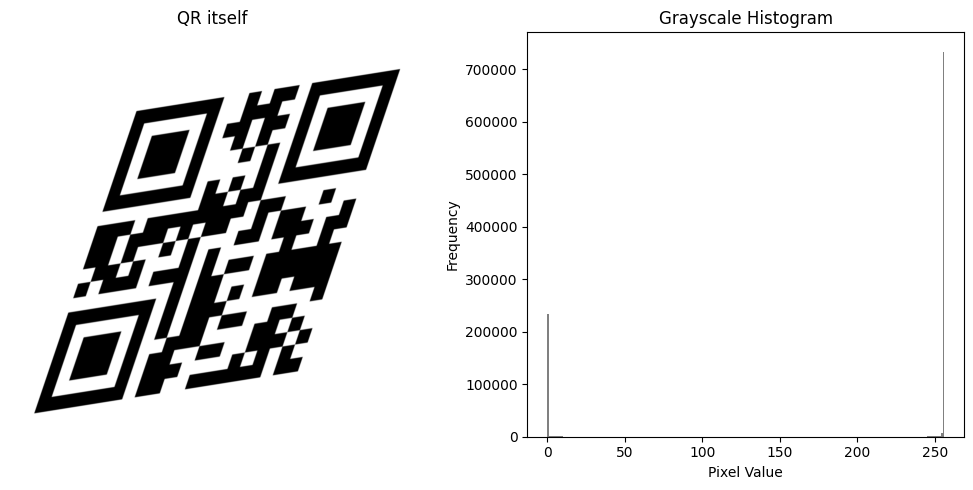

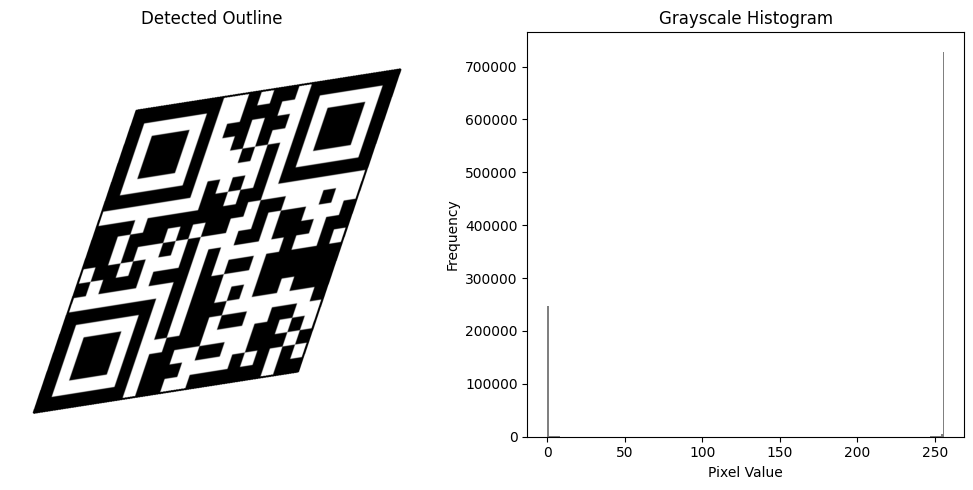

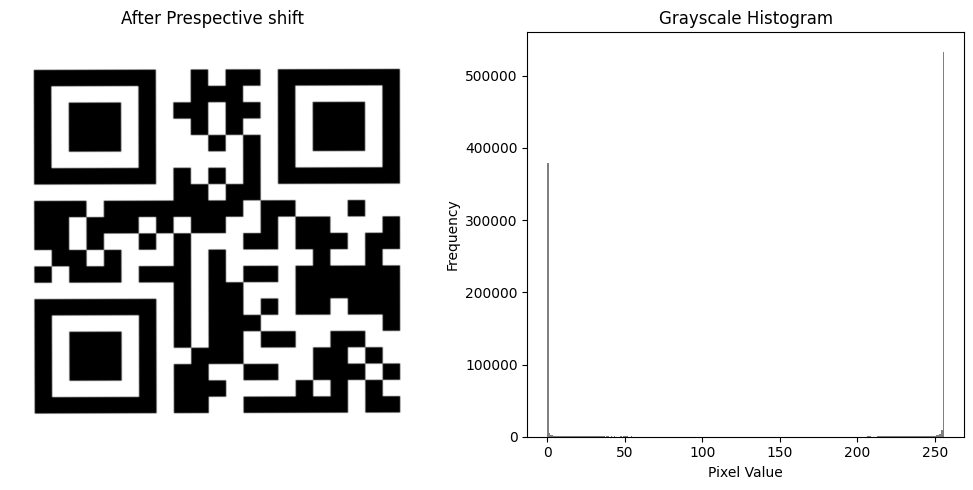

In [7]:
# Testcase 6 #
def tc06_preprocessing(original_img):

    # Find Hough
    hough_lines_6 = get_hough(original_img)
    # Find the approximate Contour
    exact,appx = get_contour(hough_lines_6)
    # Draw approximate Contour
    cont_img = original_img.copy()
    if appx is not None:
        cv2.drawContours(cont_img, [appx], -1, (0, 0, 0), 4) 
    # Fitting the QR code into a square #
    # Find contour edge vertices
    bottom_left, top_left, top_right, bottom_right = appx.reshape(-1, 2)
    # Calculate new edge vertices positions
    top_left = [top_right[0], bottom_left[1]]
    bottom_right = [bottom_left[0], top_right[1]]
    target_verticies = np.array([bottom_left, top_left, top_right, bottom_right], dtype= np.float32)
    warped_image = shift_perspective(original_img, appx, target_verticies)
    
    # Construct the printing dictionary
    printing_dict = {
        'QR itself': original_img,
        'Detected Outline' : cont_img,
        'After Prespective shift' : warped_image
    }
    return printing_dict
    
img_6 = cv2.imread('./images/06-Railfence-cipher.png', cv2.IMREAD_GRAYSCALE)
dict_6 = tc06_preprocessing(img_6)
plot_all_needed_images(dict_6)